In [ ]:
# The code does not have seed so you will get different results each time but you still get the same general result.
# However, for the discrete cases you rerun the code 3 times each and you will get the results I used. For the continuous
# case I could not get the exact results each time. 


In [119]:
!pip install --upgrade quantecon
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import sqrt, eye, zeros, cumsum
from numpy.random import randn
import scipy.linalg
from collections import namedtuple
from quantecon import nullspace, mc_sample_path, var_quadratic_sum

In [165]:
# The namedtuple function is used to store the data on the economy from the model.
Economy = namedtuple('economy', ('β',  'Sg', 'Sd', 'Sb', 'Ss', 'discrete', 'proc'))      
Path = namedtuple('path', ('g', 'd', 'b', 's', 'c', 'l', 'p', 'τ', 'rvn','B','R','π','Π', 'ξ'))           

def compute_paths(T, econ):

# β : Discount factor, Sg : Govt spending selector matrix, Sd : Exogenous endowment selector matrix, Sb : Utility parameter selector matrix
# Ss : Coupon payments selector matrix , discrete : Discrete exogenous process (True or False), proc : Stochastic process parameters
# g : Govt spending, d : Endowment, b : Utility shift parameter, s : Coupon payment on existing debt, c : Consumption
# l : Labor , p : Price, τ : Tax rate, rvn : Revenue , B : Govt debt, R : Risk-free gross return
# π : One-period risk-free interest rate , Π : Cumulative rate of return, adjusted , ξ : Adjustment factor for Π
   
    β, Sg, Sd, Sb, Ss = econ.β, econ.Sg, econ.Sd, econ.Sb, econ.Ss
    if econ.discrete:
        P, x_vals = econ.proc
    else:
        A, C = econ.proc

    # Simulate the exogenous process x
    if econ.discrete:
        state = mc_sample_path(P, init=0, sample_size=T)
        x = x_vals[:, state]
    else:
        
        nx, nx = A.shape
        x_0 = nullspace((eye(nx) - A))
        x_0 = -x_0 if (x_0[nx-1] < 0) else x_0
        x_0 = x_0 / x_0[nx-1]

        # Generate a time series x of length T starting from x0
        nx, nw = C.shape
        x = zeros((nx, T))
        w = randn(nw, T)
        x[:, 0] = x_0.T
        for t in range(1, T):
            x[:, t] = A @ x[:, t-1] + C @ w[:, t]

    # Compute exogenous variable sequences
    g, d, b, s = ((S @ x).flatten() for S in (Sg, Sd, Sb, Ss))

    # Solving for the  Lagrange multiplier in the govt budget constraint
    Sm = Sb - Sd - Ss
    # Compute a and b
    if econ.discrete:
        ns = P.shape[0]
        F = scipy.linalg.inv(eye(ns) - β * P)
        a0 = 0.5 * (F @ (x_vals.T @ Sm.T)**2)[0]
        H = ((Sb - Sd + Sg) @ x_vals) * ((Sg - Ss) @ x_vals)
        b0 = 0.5 * (F @ H.T)[0]
        a0, b0 = float(a0), float(b0)
    else:
        H = Sm.T @ Sm
        a0 = 0.5 * var_quadratic_sum(A, C, H, β, x_0)
        H = (Sb - Sd + Sg).T @ (Sg + Ss)
        b0 = 0.5 * var_quadratic_sum(A, C, H, β, x_0)
        
    # Test that ν has a real solution before assigning
    warning_msg = """
    Government spending is too high.
    """
    disc = a0**2 - 4 * a0 * b0
    if disc >= 0:
        ν = 0.5 * (a0 - sqrt(disc)) / a0
    else:
        print("There is no Ramsey equilibrium for these parameters.")
        print(warning_msg.format('high', 'Republican'))
        sys.exit(0)

    # Test that the Lagrange multiplier has the right sign
    if ν * (0.5 - ν) < 0:
        print("Negative multiplier on the government budget constraint.")
        print(warning_msg.format('low', 'Democratic'))
        sys.exit(0)

    # Solve for the allocation given ν and x
    Sc = 0.5 * (Sb + Sd - Sg - ν * Sm)
    Sl = 0.5 * (Sb - Sd + Sg - ν * Sm)
    c = (Sc @ x).flatten()
    l = (Sl @ x).flatten()
    p = ((Sb - Sc) @ x).flatten()  # Price without normalization
    τ = 1 - l / (b - c)
    rvn = l * τ

    # Compute remaining variables
    if econ.discrete:
        H = ((Sb - Sc) @ x_vals) * ((Sl - Sg) @ x_vals) - (Sl @ x_vals)**2
        temp = (F @ H.T).flatten()
        B = temp[state] / p
        H = (P[state, :] @ x_vals.T @ (Sb - Sc).T).flatten()
        R = p / (β * H)
        temp = ((P[state, :] @ x_vals.T @ (Sb - Sc).T)).flatten()
        ξ = p[1:] / temp[:T-1]
    else:
        H = Sl.T @ Sl - (Sb - Sc).T @ (Sl - Sg)
        L = np.empty(T)
        for t in range(T):
            L[t] = var_quadratic_sum(A, C, H, β, x[:, t])
        B = L / p
        Rinv = (β * ((Sb - Sc) @ A @ x)).flatten() / p
        R = 1 / Rinv
        AF1 = (Sb - Sc) @ x[:, 1:]
        AF2 = (Sb - Sc) @ A @ x[:, :T-1]
        ξ = AF1 / AF2
        ξ = ξ.flatten()

    π = B[1:] - R[:T-1] * B[:T-1] - rvn[:T-1] + g[:T-1]
    Π = cumsum(π * ξ)

    # Prepare return values
    path = Path(g=g, d=d, b=b, s=s, c=c, l=l, p=p,
                τ=τ, rvn=rvn, B=B, R=R, π=π, Π=Π, ξ=ξ)

    return path


def gen_fig(path):
    """
    """

    T = len(path.c)

    # Prepare the graphs axes
    num_rows, num_cols = 2, 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].grid()
            axes[i, j].set_xlabel('Time')
    bbox = (0., 1.02, 1., .102)
    legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
    p_args = {'lw': 2, 'alpha': 0.7}

    # Plot consumption, govt expenditure and revenue
    ax = axes[0, 0]
    ax.plot(path.rvn, label=r'$\tau_t \ell_t$', **p_args)
    ax.plot(path.g, label='$g_t$', **p_args)
    ax.plot(path.c, label='$c_t$', **p_args)
    ax.legend(ncol=3, **legend_args)

    # Plot govt expenditure and debt
    ax = axes[0, 1]
    ax.plot(list(range(1, T+1)), path.rvn, label=r'$\tau_t \ell_t$', **p_args)
    ax.plot(list(range(1, T+1)), path.g, label='$g_t$', **p_args)
    ax.plot(list(range(1, T)), path.B[1:T], label='$B_{t+1}$', **p_args)
    ax.legend(ncol=3, **legend_args)

    # Plot risk-free return
    ax = axes[1, 0]
    ax.plot(list(range(1, T+1)), path.R - 1, label='$R_t - 1$', **p_args)
    ax.legend(ncol=1, **legend_args)

    # Plot revenue, expenditure and risk free rate
    ax = axes[1, 1]
    ax.plot(list(range(1, T+1)), path.rvn, label=r'$\tau_t \ell_t$', **p_args)
    ax.plot(list(range(1, T+1)), path.g, label='$g_t$', **p_args)
    axes[1, 1].plot(list(range(1, T)), path.π, label=r'$\pi_{t+1}$', **p_args)
    ax.legend(ncol=3, **legend_args)

    plt.show()




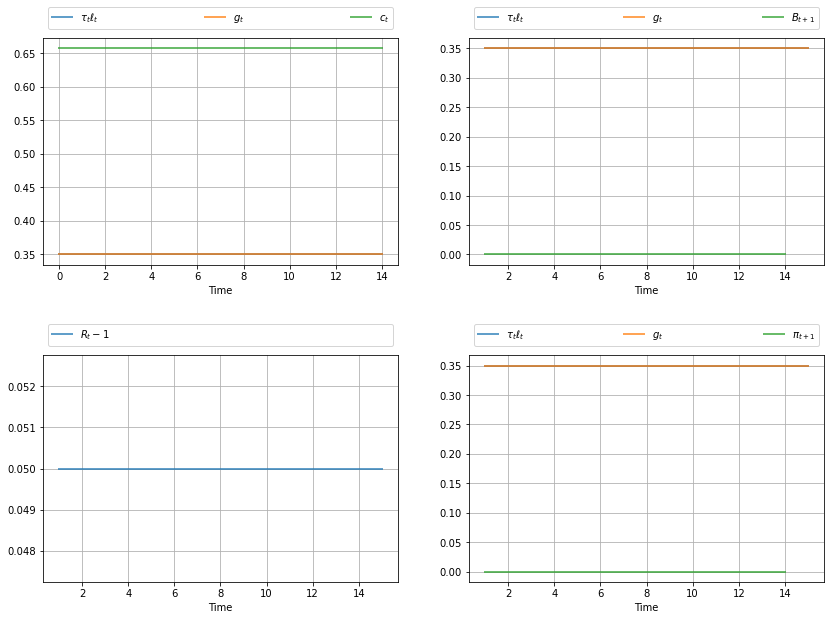

In [166]:
# d_m1
β = 1 / 1.05
P = np.array([[0.8, 0.2, 0.0],
            [0.0, 0.5, 0.5],
            [0.0, 0.0, 1.0]])

# Possible states of the world
# Each column is a state of the world. The rows are [g d b s 1]
x_vals = np.array([[0.35, 0.35, 0.35],
                [0.0, 0.0,  0.0],
                [2.2, 2.2,  2.2],
                [0, 0,  0],
                [1.0, 1.0,  1.0]])

Sg = np.array((1, 0, 0, 0, 0)).reshape(1, 5)
Sd = np.array((0, 1, 0, 0, 0)).reshape(1, 5)
Sb = np.array((0, 0, 1, 0, 0)).reshape(1, 5)
Ss = np.array((0, 0, 0, 1, 0)).reshape(1, 5)

economy = Economy(β=β, Sg=Sg, Sd=Sd, Sb=Sb, Ss=Ss,
                discrete=True, proc=(P, x_vals))

T = 15
path = compute_paths(T, economy)
gen_fig(path)

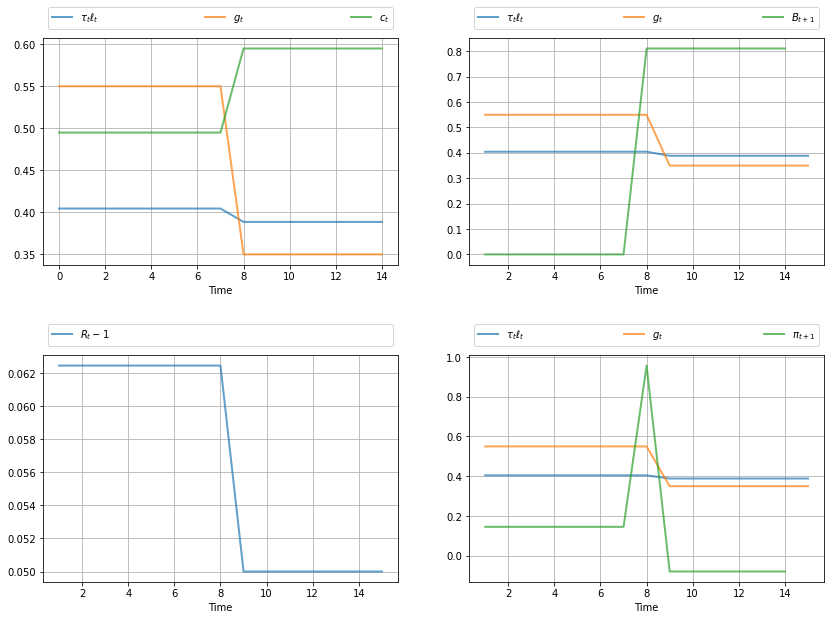

In [167]:
# d_m2
β = 1 / 1.05
P = np.array([[0.8, 0.2, 0.0],
            [0.0, 0.5, 0.5],
            [0.0, 0.0, 1.0]])

x_vals = np.array([[0.55, 0.35, 0.35],
                [0.0, 0.0,  0.0],
                [2.2, 2.2,  2.2],
                [0, 0,  0],
                [1.0, 1.0,  1.0]])

Sg = np.array((1, 0, 0, 0, 0)).reshape(1, 5)
Sd = np.array((0, 1, 0, 0, 0)).reshape(1, 5)
Sb = np.array((0, 0, 1, 0, 0)).reshape(1, 5)
Ss = np.array((0, 0, 0, 1, 0)).reshape(1, 5)

economy = Economy(β=β, Sg=Sg, Sd=Sd, Sb=Sb, Ss=Ss,
                discrete=True, proc=(P, x_vals))

T = 15
path = compute_paths(T, economy)
gen_fig(path)

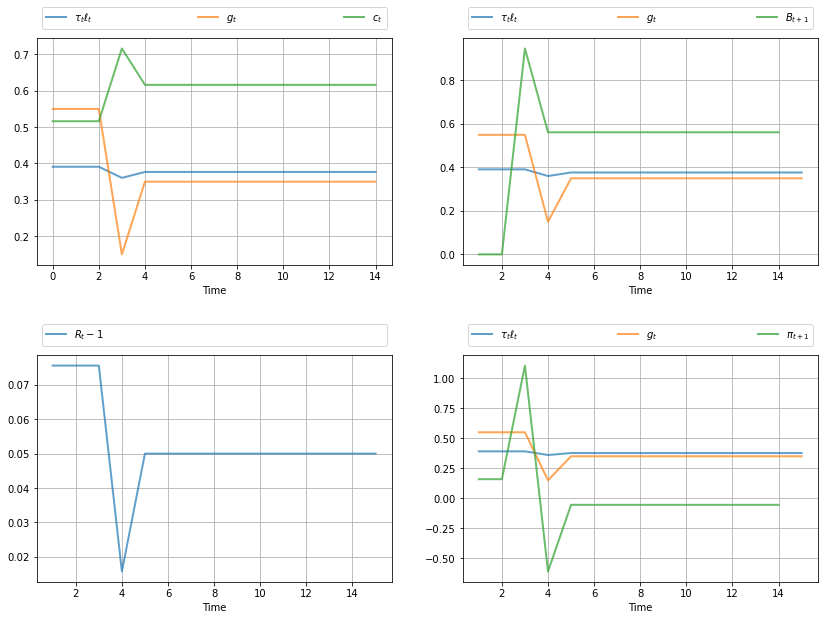

In [168]:
# d_m3
β = 1 / 1.05
P = np.array([[0.8, 0.2, 0.0],
            [0.0, 0.5, 0.5],
            [0.0, 0.0, 1.0]])

# Possible states of the world
# Each column is a state of the world. The rows are [g d b s 1]
x_vals = np.array([[0.55, 0.15, 0.35],
                [0.0, 0.0,  0.0],
                [2.2, 2.2,  2.2],
                [0, 0,  0],
                [1.0, 1.0,  1.0]])

Sg = np.array((1, 0, 0, 0, 0)).reshape(1, 5)
Sd = np.array((0, 1, 0, 0, 0)).reshape(1, 5)
Sb = np.array((0, 0, 1, 0, 0)).reshape(1, 5)
Ss = np.array((0, 0, 0, 1, 0)).reshape(1, 5)

economy = Economy(β=β, Sg=Sg, Sd=Sd, Sb=Sb, Ss=Ss,
                discrete=True, proc=(P, x_vals))

T = 15
path = compute_paths(T, economy)
gen_fig(path)

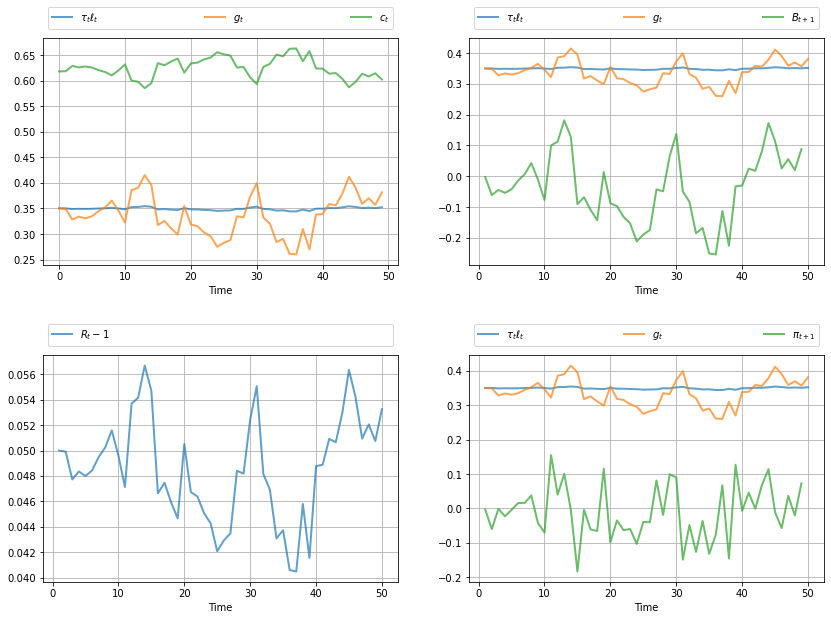

In [169]:
# =c_m1
β = 1 / 1.05
ρ, mg = .8, .3
A = eye(2)
A[0, :] = ρ, mg * (1-ρ)
C = np.zeros((2, 1))
C[0, 0] = np.sqrt(1 - ρ**2) * mg / 10
Sg = np.array((1, 0)).reshape(1, 2)
Sd = np.array((0, 0)).reshape(1, 2)
Sb = np.array((0, 2.135)).reshape(1, 2)
Ss = np.array((0, 0)).reshape(1, 2)

economy = Economy(β=β, Sg=Sg, Sd=Sd, Sb=Sb, Ss=Ss,
                discrete=False, proc=(A, C))

T = 50
path = compute_paths(T, economy)
gen_fig(path)

In [ ]:
# =c_m2
β = 1 / 1.05
ρ, mg = .8, .3
A = eye(2)
A[0, :] = ρ, mg * (1-ρ)
C = np.zeros((2, 1))
C[0, 0] = np.sqrt(1 - ρ**2) * mg / 10
Sg = np.array((1, 0)).reshape(1, 2)
Sd = np.array((0, 0)).reshape(1, 2)
Sb = np.array((0, 2.135)).reshape(1, 2)
Ss = np.array((0, 0)).reshape(1, 2)

economy = Economy(β=β, Sg=Sg, Sd=Sd, Sb=Sb, Ss=Ss,
                discrete=False, proc=(A, C))

T = 100
path = compute_paths(T, economy)
gen_fig(path)

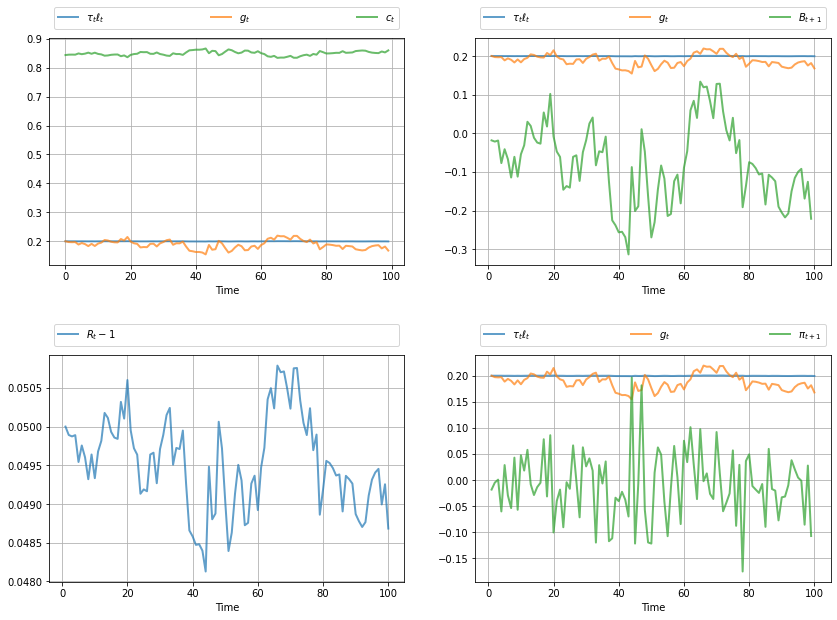

In [170]:
# =c_m3
β = 1 / 1.05
ρ, mg = .9, .2
A = eye(2)
A[0, :] = ρ, mg * (1-ρ)
C = np.zeros((2, 1))
C[0, 0] = np.sqrt(1 - ρ**2) * mg / 10
Sg = np.array((1, 0)).reshape(1, 2)
Sd = np.array((0, 0)).reshape(1, 2)
Sb = np.array((0, 2.135)).reshape(1, 2)
Ss = np.array((0, 0)).reshape(1, 2)

economy = Economy(β=β, Sg=Sg, Sd=Sd, Sb=Sb, Ss=Ss,
                discrete=False, proc=(A, C))

T = 100
path = compute_paths(T, economy)
gen_fig(path)